In [3]:
# !pip install -U lightautoml==0.3.8b1 

^C


ERROR: Could not install packages due to an OSError: [WinError 32] Процесс не может получить доступ к файлу, так как этот файл занят другим процессом: 'C:\\Users\\user\\.conda\\envs\\py310\\Lib\\site-packages\\plotly\\validators\\mesh3d\\colorbar\\tickformatstop\\_value.py'
Consider using the `--user` option or check the permissions.



  Obtaining dependency information for lightautoml==0.3.8b1 from https://files.pythonhosted.org/packages/ff/4d/e4e181da6cfa5326ca564b68f4b3878062f694aa4027099d002ba152139e/lightautoml-0.3.8b1-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/215.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/215.7 kB ? eta -:--:--
     ------------ ------------------------ 71.7/215.7 kB 787.7 kB/s eta 0:00:01
     -------------------------------------- 215.7/215.7 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
     ---------------------------------------- 0.2/101.0 MB 4.6 MB/s eta 0:00:22
     ---------------------------------------- 0.4/101.0 MB 5.0 MB/s eta 0:00:21
     ---------------------------------------- 0.7/101.0 MB 5.7 MB/s eta 0:00:18
     ---------------------------------------- 1.0/101.0 MB 5.6 MB/s eta 0:00:18
     ---------------------------------------- 1.2/101.0 MB 5.6 MB/s eta 0:00:18
  

In [1]:
# Standard python libraries
import os
import time
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

ModuleNotFoundError: No module named 'torch'

In [123]:
# set some constants for reproducibility

RANDOM_STATE = 42
N_THREADS = 6

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

## 1. Загрузка данных

In [132]:
TARGET_NAME = 'Survived'

data = pd.read_csv('data/X_train.csv', index_col='PassengerId')
data.sample(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,status,is_alone,age*class
PassengerId,,,,,,,,,
385,0,3,0,1,0,0,1,1,3
211,0,3,0,1,0,0,1,1,3
487,1,1,1,2,3,0,3,0,2
426,0,3,0,1,0,0,1,1,3
856,1,3,1,1,1,0,3,0,3


Разделим данные на обучение и тест

In [133]:
train_data, test_data = train_test_split(
    data,
    test_size=0.2, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data splitted. Parts sizes: train_data = (712, 9), test_data = (179, 9)


,Survived,Pclass,Sex,Age,Fare,Embarked,status,is_alone,age*class
PassengerId,,,,,,,,,
693,1,3,0,1,3,0,1,1,3
482,0,2,0,1,0,0,1,1,2
528,0,1,0,2,3,0,1,1,2
856,1,3,1,1,1,0,3,0,3
802,1,2,1,1,2,0,3,0,2


## 2. Создание и обучение пресета `TabularAutoML`

In [18]:
# specify task type
#  'binary' - for binary classification.
#  'reg' - for regression.
#  'multiclass' - for multiclass classification.
task = Task(
    'binary',  # required
    loss='logloss',
    metric='auc'
)

In [19]:
# specify feature roles
roles = {
    'target': TARGET_NAME,  # required
    # 'drop': ['SK_ID_CURR']  # remove user's id
}

In [140]:
N_FOLDS = 5
TIMEOUT = 60 * 30

In [141]:
RD = ReportDeco(output_path='tabularAutoML_model_report')

automl = TabularAutoML(
    task=task,  # required
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

automl_rd = RD(automl)

In [142]:
%%time
oof_preds = automl_rd.fit_predict(data, roles=roles, verbose=1)

[18:06:08] Stdout logging level is INFO.
[18:06:08] Task: binary

[18:06:08] Start automl preset with listed constraints:
[18:06:08] - time: 1800.00 seconds
[18:06:08] - CPU: 6 cores
[18:06:08] - memory: 16 GB

[18:06:08] Train data shape: (891, 9)

[18:06:12] Layer 1 train process start. Time left 1795.98 secs
[18:06:12] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[18:06:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.858642507909117
[18:06:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[18:06:13] Time left 1794.98 secs

[18:06:13] Selector_LightGBM fitting and predicting completed
[18:06:13] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[18:06:13] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.8483606557377049
[18:06:13] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[18:06:13] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[18:06:38] Hyperparameters optimization for Lvl_0_

C:\Users\user\.conda\envs\py310\lib\site-packages\lightautoml\report\report_deco.py:146: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
C:\Users\user\.conda\envs\py310\lib\site-packages\lightautoml\report\report_deco.py:153: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


CPU times: total: 5min 50s
Wall time: 1min 20s


In [24]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.14590 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.38475 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.22921 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.24014 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [25]:
%%time

test_preds = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_preds}\nShape = {test_preds.shape}')

Prediction for te_data:
array([[0.12914559],
       [0.17647354],
       [0.17373404],
       [0.12739071],
       [0.7089284 ],
       [0.36840323],
       [0.8266529 ],
       [0.5308667 ],
       [0.6082238 ],
       [0.181595  ],
       [0.15218209],
       [0.14246273],
       [0.5367686 ],
       [0.2225944 ],
       [0.351935  ],
       [0.18091604],
       [0.17775087],
       [0.12229836],
       [0.12504643],
       [0.847717  ],
       [0.12229836],
       [0.78074265],
       [0.23828375],
       [0.38923475],
       [0.16355993],
       [0.9082637 ],
       [0.38056844],
       [0.44663554],
       [0.18376929],
       [0.21937752],
       [0.19155622],
       [0.9149508 ],
       [0.29041556],
       [0.26962242],
       [0.28971064],
       [0.57335335],
       [0.19228572],
       [0.18906401],
       [0.15218209],
       [0.8626186 ],
       [0.36818367],
       [0.8977706 ],
       [0.14157142],
       [0.84728354],
       [0.84899265],
       [0.14267784],
       [0.

Используем метрику ROC-AUC для оценки качества

In [48]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_preds.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_preds.data[:, 0])}')
print(f'accuracy - {accuracy_score(test_data[TARGET_NAME].values, (test_preds.data > 0.5).astype(int)[:, 0])}')

OOF score: 0.8841022303436883
HOLDOUT score: 0.8306324110671937
accuracy - 0.7821229050279329


Пресет `TabularAutoML` обучался 6.5 минут, несмотря на то, что `TIMEOUT` установлен равным 30 минутам. Чтобы использовать отведенное время, воспользуемся пресетом `TabularUtilizedAutoML` вместо `TabularAutoML`.

## 3. Создание и обучение `TabularUtilizedAutoML`

In [134]:
N_FOLDS = 5
TIMEOUT = 60 * 30

In [137]:
RD = ReportDeco(output_path='tabularAutoML_model_report')

utilized_automl = TabularUtilizedAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

automl_rd = RD(utilized_automl)

In [138]:
%%time 
oof_pred = automl_rd.fit_predict(data, roles=roles, verbose=1)

[16:59:34] Start automl utilizator with listed constraints:
[16:59:34] - time: 1800.00 seconds
[16:59:34] - CPU: 6 cores
[16:59:34] - memory: 16 GB

[16:59:34] If one preset completes earlier, next preset configuration will be started

[16:59:34] ==================================================
[16:59:34] Start 0 automl preset configuration:
[16:59:34] C:\Users\user\.conda\envs\py310\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[16:59:34] Stdout logging level is INFO.
[16:59:34] Task: binary

[16:59:34] Start automl preset with listed constraints:
[16:59:34] - time: 1800.00 seconds
[16:59:34] - CPU: 6 cores
[16:59:34] - memory: 16 GB

[16:59:34] Train data shape: (891, 9)

[16:59:39] Layer 1 train process start. Time left 1795.82 secs
[16:59:39] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:59:40] Fitt

AttributeError: 'TabularUtilizedAutoML' object has no attribute 'reader'

In [52]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.23607 * 4 averaged models with config = "C:\Users\user\.conda\envs\py310\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.28193 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.47539 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.05252 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.19017 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #1.
		Final prediction for new objects (level 0) = 
			 0.08394 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.23007 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.28994 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.39605 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #2.
		Final prediction for new objects (level 0) = 
			 0.15320 * (5 averaged

In [94]:
%%time

y_pred = utilized_automl.predict(data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[0.14585489],
       [0.16585813],
       [0.2662741 ],
       [0.13310611],
       [0.65276104],
       [0.53244996],
       [0.7502618 ],
       [0.3929063 ],
       [0.44276482],
       [0.19617487],
       [0.15953863],
       [0.16362548],
       [0.5929251 ],
       [0.23677787],
       [0.29411116],
       [0.19010392],
       [0.27384022],
       [0.14730467],
       [0.15620841],
       [0.7655914 ],
       [0.14730467],
       [0.7705686 ],
       [0.18753834],
       [0.52741235],
       [0.17071906],
       [0.87166953],
       [0.22277121],
       [0.36721265],
       [0.2586328 ],
       [0.22715242],
       [0.15943545],
       [0.8618767 ],
       [0.35926962],
       [0.2538312 ],
       [0.47385633],
       [0.5691122 ],
       [0.4411194 ],
       [0.14949521],
       [0.15953863],
       [0.79161704],
       [0.2870721 ],
       [0.79487026],
       [0.18270013],
       [0.7726221 ],
       [0.7797998 ],
       [0.15968624],
       [0.

In [95]:
print(f'OOF score: {roc_auc_score(data[TARGET_NAME].values, y_pred.data[:, 0])}')
print(f'accuracy - {accuracy_score(data[TARGET_NAME].values, (y_pred.data > 0.5).astype(int)[:, 0])}')

OOF score: 0.9383381799976565
accuracy - 0.8810325476992144


In [90]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])}')
print(f'accuracy - {accuracy_score(test_data[TARGET_NAME].values, (test_preds.data > 0.53).astype(int)[:, 0])}')

OOF score: 0.9013325323120313
HOLDOUT score: 0.8347826086956522
accuracy - 0.7877094972067039


Метрика ROC-AUC немного подросла

In [119]:
X_test = pd.read_csv('data/test.csv')

In [120]:
answer = pd.read_csv('data/gender_submission.csv')
answer.Survived = (utilized_automl.predict(X_test).data > 0.5).astype(int)[:, 0]

In [121]:
answer.to_csv('data/answer.csv', index=False)

In [122]:
answer.groupby('Survived').count()

,PassengerId
Survived,
0,277
1,141


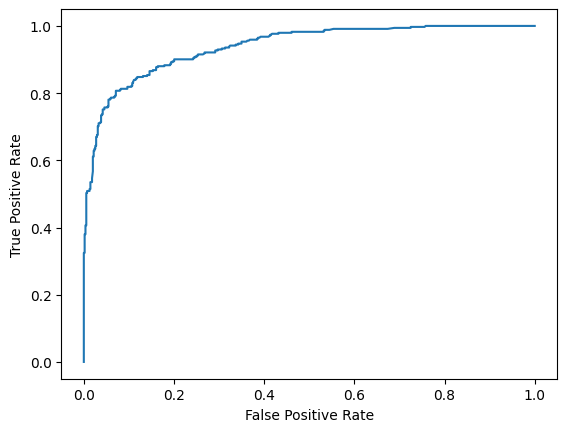

In [96]:
fpr, tpr, _ = roc_curve(data[TARGET_NAME].values, y_pred.data[:, 0])

#create ROC curve
plt.plot (fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 